In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "converter"

In [2]:
from web3 import Web3

INFURA_API_KEY = os.getenv("INFURA_API_KEY")
w3 = Web3(Web3.HTTPProvider(f"https://mainnet.infura.io/v3/{INFURA_API_KEY}"))

In [3]:
import time
from langchain_core.tools import tool

from graph.tools.abi import fetch_contract_abi
from graph.tools.address import (
    resolve_ens,
    get_contract_address_by_name,
    convert_to_checksum_address,
)


@tool
def get_token_info(token_address: str) -> dict:
    """
    Retrieve the token information (symbol, name, decimals) from an ERC-20 token contract.

    Args:
        token_address (str): The Ethereum address of the token contract.

    Returns:
        dict: A dictionary containing the token's symbol, name, and decimals.

    Example:
        token_info = get_token_info('0xae7ab96520de3a18e5e111b5eaab095312d7fe84')
        print(token_info)  # Outputs: {'decimals': 18, 'symbol': 'stETH', 'name': 'Lido Staked Ether'}
    """
    # Create the contract object
    contract = w3.eth.contract(
        address=token_address,
        abi=fetch_contract_abi.invoke(
            {"contract_address": token_address, "contract_type": "erc20"}
        ),
    )

    with w3.batch_requests() as batch:
        batch.add(contract.functions.symbol())
        batch.add(contract.functions.name())
        batch.add(contract.functions.decimals())
        responses = batch.execute()

    return {
        "symbol": responses[0],
        "name": responses[1],
        "decimals": responses[2],
    }


@tool
def convert_to_token_amount(amount: float, decimals: int) -> int:
    """
    Convert a human-readable token amount to its smallest unit (wei-like amount).

    Args:
        amount (float): The human-readable token amount (e.g., 400 for 400 stETH).
        decimals (int): The number of decimals the token uses (e.g., 18 for stETH).

    Returns:
        int: The token amount in the smallest unit (e.g., wei for stETH).

    Example:
        token_amount = convert_to_token_amount(400, 18)
        print(token_amount)  # Outputs: 400 * (10 ** 18)
    """
    return int(amount * (10**decimals))


@tool
def encode_function_call(abi: list, function_name: str, args: list) -> str:
    """
    Encode a smart contract function call into ABI-encoded data.

    This function takes the relevant function's ABI, the name of the function to call, and its arguments,
    and then returns the ABI-encoded data that can be included in the transaction's data field.

    Args:
        abi (str): The ABI of the contract in JSON format.
        function_name (str): The name of the contract function to call (e.g., 'approve').
        args (list): The arguments to the function as a list (e.g., [spender_address, amount]).

    Returns:
        str: The ABI-encoded data for the function call that can be used in a transaction.

    Example:
        data = encode_function_call(abi, 'approve', ['0xUniswapContractAddress', 400])
    """
    contract = w3.eth.contract(abi=abi)
    return contract.encode_abi(function_name, args)


@tool
def convert_dec_to_hex(integer: int) -> str:
    """
    Convert an decimal integer to a hexadecimal string.

    Args:
        integer (int): The integer to be converted.

    Returns:
        str: The hexadecimal representation of the input integer, prefixed with '0x'.

    Example:
        hex_value = convert_int_to_hex(255)
        print(hex_value)  # Outputs: '0xff'
    """
    return w3.to_hex(integer)


@tool
def get_current_timestamp() -> int:
    """
    Get the current Unix timestamp.

    Returns:
        int: The current Unix timestamp.
    """
    return int(time.time())

### Custom Agent to Output Tx Params using Tool


In [4]:
from typing import Literal

from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


class TransactionParams(BaseModel):
    """
    Convert the final result into transaction parameters.
    """

    from_address: str = Field(description="The address of the sender (from)")
    to_address: str = Field(description="The address being interacted with (to)")
    data: str = Field("0x", description="Transaction data in hex, start with '0x'")
    value: str = Field("0x0", description="Amount of native token to send, in hex")

    @validator("from_address", "to_address")
    def check_address_format(cls, v):
        if not v.startswith("0x"):
            raise ValueError("Address must start with '0x'")
        if len(v) != 42:
            raise ValueError("Address must be 42 characters long")
        return v

    @validator("value")
    def check_value_format(cls, v):
        if not v.startswith("0x"):
            raise ValueError("Value must start with '0x'")
        return v

    @validator("data")
    def check_data_format(cls, v):
        if not v.startswith("0x"):
            raise ValueError("Data must start with '0x'")
        return v

    def __str__(self):
        return f"From: {self.from_address}\nTo: {self.to_address}\nData: {self.data}\nValue: {self.value}"


tools = [
    fetch_contract_abi,
    get_contract_address_by_name,
    resolve_ens,
    convert_to_checksum_address,
    encode_function_call,
    get_token_info,
    convert_to_token_amount,
    convert_dec_to_hex,
    TransactionParams,
]

model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0)
model_with_tools = model.bind_tools(tools)


class AgentInput(MessagesState):
    pass


class AgentOutput(MessagesState):
    response: TransactionParams


class AgentState(MessagesState):
    response: TransactionParams


def call_model(state: AgentState):
    response = model_with_tools.invoke(state["messages"])
    return {"messages": [response]}


def convert(state: AgentState):
    messages = state["messages"]
    # Construct tx params from the arguments of the last tool call
    tx_params = TransactionParams(**messages[-1].tool_calls[0]["args"])
    return {"response": tx_params}


def should_continue(state: AgentState) -> Literal["convert", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "TransactionParams"
    ):
        return "convert"

    return "continue"


workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("converter", convert)
workflow.add_node("tools", ToolNode(tools))

workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent", should_continue, {"convert": "converter", "continue": "tools"}
)
workflow.add_edge("tools", "agent")
workflow.set_finish_point("converter")

app = workflow.compile()

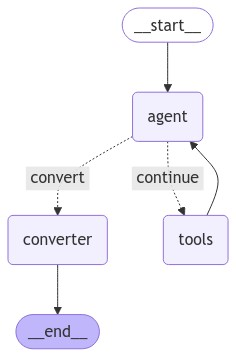

In [5]:
from utils.printer import print_graph

print_graph(app)

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage


system_prompt = """Interpret the provided description to generate Ethereum transaction parameters using the following tools:
-------------
- fetch_contract_abi: Retrieve the ABI for a contract by address or function name.
- get_contract_address_by_name: Get a contract address using a protocol or token name.
- resolve_ens: Convert an ENS domain to an Ethereum address.
- convert_to_checksum_address: Format an Ethereum address to checksum format.
- encode_function_call: Encode a function call and its arguments using the ABI.
- get_token_info: Retrieve token details (name, symbol, decimals) by address.
- convert_to_token_amount: Convert a token amount to its smallest unit (e.g., wei) based on decimals.
- convert_dec_to_hex: Convert a decimal integer to a hexadecimal string.
-------------
Once you have the transaction encoded data (using tool 'encode_function_call'), finalize by using `convert_to_tx_params` to create a TransactionParams object and return it.
Sender address: {from_address}
Current time: {current_time}"""

In [7]:
from datetime import datetime


async def generate_tx_params(description: str, from_address: str) -> TransactionParams:
    system_message = SystemMessage(
        system_prompt.format(from_address=from_address, current_time=datetime.now())
    )
    input = {"messages": [system_message, HumanMessage(description)]}
    result = await app.ainvoke(input)
    return result["response"]

In [8]:
from_address = "0xd8da6bf26964af9d7eed9e03e53415d37aa96045"

In [9]:
description = "Send 0.01 ETH to the address 0x8c575b178927fF9A70804B8b4F7622F7666bB360."
res = await generate_tx_params(description, from_address)
print(res)

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0x8c575b178927fF9A70804B8b4F7622F7666bB360".lower()
assert res.data == "0x"
assert res.value == "0x2386f26fc10000"

From: 0xd8da6bf26964af9d7eed9e03e53415d37aa96045
To: 0x8c575b178927fF9A70804B8b4F7622F7666bB360
Data: 0x
Value: 0x2386f26fc10000


In [10]:
description = "Transfer 100 USDT to Scott's Ethereum address."
res = await generate_tx_params(description, from_address)
print(res)

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0xdAC17F958D2ee523a2206206994597C13D831ec7".lower()
data = "0xa9059cbb000000000000000000000000b859d7eb5e319e54dc23c83dfe93e649b88202b60000000000000000000000000000000000000000000000000000000005f5e100"
assert res.data == data
assert res.value == "0x0"

Fetching ABI from Etherscan for address: 0xdac17f958d2ee523a2206206994597c13d831ec7
Not a proxy contract, returning the ABI
From: 0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045
To: 0xdAC17F958D2ee523a2206206994597C13D831ec7
Data: 0xa9059cbb000000000000000000000000b859d7eb5e319e54dc23c83dfe93e649b88202b60000000000000000000000000000000000000000000000000000000005f5e100
Value: 0x0


In [11]:
description = "Approve 100 USDT for swapping on a decentralized exchange."
res = await generate_tx_params(description, from_address)
print(res)

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0xdAC17F958D2ee523a2206206994597C13D831ec7".lower()
data = "0x095ea7b30000000000000000000000007a250d5630b4cf539739df2c5dacb4c659f2488d0000000000000000000000000000000000000000000000000000000005f5e100"
assert res.data == data
assert res.value == "0x0"

Not a proxy contract, returning the ABI
From: 0xd8da6bf26964af9d7eed9e03e53415d37aa96045
To: 0xdAC17F958D2ee523a2206206994597C13D831ec7
Data: 0x095ea7b30000000000000000000000007a250d5630b4cf539739df2c5dacb4c659f2488d0000000000000000000000000000000000000000000000000000000005f5e100
Value: 0x0


In [12]:
description = "Swap 100 USDT to USDC on the chosen decentralized exchange."
res = await generate_tx_params(description, from_address)
print(res)

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D".lower()
# Data is omitted since deadline is not deterministic
assert res.value == "0x0"

Fetching ABI from Etherscan for address: 0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D
Not a proxy contract, returning the ABI
From: 0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045
To: 0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D
Data: 0x38ed17390000000000000000000000000000000000000000000000000000000005f5e100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0000000000000000000000000d8da6bf26964af9d7eed9e03e53415d37aa960450000000000000000000000000000000000000000000000000000000066e43fe50000000000000000000000000000000000000000000000000000000000000002000000000000000000000000dac17f958d2ee523a2206206994597c13d831ec7000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
Value: 0x0


In [13]:
description = "Stake 0.03 ETH to Lido to receive stETH."
res = await generate_tx_params(description, from_address)
print(res)

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84".lower()
data = "0xa1903eab0000000000000000000000000000000000000000000000000000000000000000"
assert res.data == data
assert res.value == "0x6a94d74f430000"

Fetching ABI from Etherscan for address: 0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Proxy contract detected at 0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Implementation address: 0x17144556fd3424EDC8Fc8A4C940B2D04936d17eb
Fetching ABI from Etherscan for address: 0x17144556fd3424EDC8Fc8A4C940B2D04936d17eb
Not a proxy contract, returning the ABI
From: 0xd8da6bf26964af9d7eed9e03e53415d37aa96045
To: 0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Data: 0xa1903eab0000000000000000000000000000000000000000000000000000000000000000
Value: 0x6a94d74f430000


### Custom Agent to Output Tx Params using LLM


In [14]:
from typing import Literal

from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

from graph.tools.simulation import TransactionParams


tools = [
    fetch_contract_abi,
    get_contract_address_by_name,
    resolve_ens,
    convert_to_checksum_address,
    encode_function_call,
    get_token_info,
    convert_to_token_amount,
    convert_dec_to_hex,
]

model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0)
model_with_tools = model.bind_tools(tools)
model_with_structured_output = model.with_structured_output(TransactionParams)


class AgentInput(MessagesState):
    pass


class AgentOutput(MessagesState):
    response: TransactionParams


class AgentState(MessagesState):
    response: TransactionParams


def call_model(state: AgentState):
    response = model_with_tools.invoke(state["messages"])
    return {"messages": [response]}


def convert(state: AgentState):
    messages = state["messages"]
    # Construct tx params from the arguments of the last tool call
    tx_params = model_with_structured_output.invoke(messages)
    return {"response": tx_params}


def should_continue(state: AgentState) -> Literal["convert", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "convert"

    return "continue"


workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("converter", convert)
workflow.add_node("tools", ToolNode(tools))

workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent", should_continue, {"convert": "converter", "continue": "tools"}
)
workflow.add_edge("tools", "agent")
workflow.set_finish_point("converter")

app = workflow.compile()

In [15]:
from langchain_core.messages import HumanMessage, SystemMessage


system_prompt = """Interpret the provided description to generate Ethereum transaction parameters using the following tools:
-------------
- fetch_contract_abi: Retrieve the ABI for a contract by address or function name.
- get_contract_address_by_name: Get a contract address using a protocol or token name.
- resolve_ens: Convert an ENS domain to an Ethereum address.
- convert_to_checksum_address: Format an Ethereum address to checksum format.
- encode_function_call: Encode a function call and its arguments using the ABI.
- get_token_info: Retrieve token details (name, symbol, decimals) by address.
- convert_to_token_amount: Convert a token amount to its smallest unit (e.g., wei) based on decimals.
- convert_dec_to_hex: Convert a decimal integer to a hexadecimal string.
-------------
Once you have the transaction encoded data, return the transaction parameters (from, to, data, value).
Sender address: {from_address}
Current time: {current_time}"""


from datetime import datetime


async def generate_tx_params(description: str, from_address: str) -> TransactionParams:
    system_message = SystemMessage(
        system_prompt.format(from_address=from_address, current_time=datetime.now())
    )
    input = {"messages": [system_message, HumanMessage(description)]}
    result = await app.ainvoke(input)
    return result["response"]


from_address = "0xd8da6bf26964af9d7eed9e03e53415d37aa96045"

In [16]:
description = "Send 0.01 ETH to the address 0x8c575b178927fF9A70804B8b4F7622F7666bB360."
res = await generate_tx_params(description, from_address)
print(res.json())

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0x8c575b178927fF9A70804B8b4F7622F7666bB360".lower()
assert res.data == "0x"
assert res.value == "0x2386f26fc10000"

{"from_address": "0xd8da6bf26964af9d7eed9e03e53415d37aa96045", "to_address": "0x8c575b178927fF9A70804B8b4F7622F7666bB360", "data": "0x", "value": "0x2386f26fc10000"}


In [17]:
description = "Transfer 100 USDT to Scott's Ethereum address."
res = await generate_tx_params(description, from_address)
print(res.json())

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0xdAC17F958D2ee523a2206206994597C13D831ec7".lower()
data = "0xa9059cbb000000000000000000000000b859d7eb5e319e54dc23c83dfe93e649b88202b60000000000000000000000000000000000000000000000000000000005f5e100"
assert res.data == data
assert res.value == "0x0"

{"from_address": "0xd8da6bf26964af9d7eed9e03e53415d37aa96045", "to_address": "0xdAC17F958D2ee523a2206206994597C13D831ec7", "data": "0xa9059cbb000000000000000000000000b859d7eb5e319e54dc23c83dfe93e649b88202b60000000000000000000000000000000000000000000000000000000005f5e100", "value": "0x0"}


In [18]:
description = "Approve 100 USDT for swapping on a decentralized exchange."
res = await generate_tx_params(description, from_address)
print(res.json())

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0xdAC17F958D2ee523a2206206994597C13D831ec7".lower()
data = "0x095ea7b30000000000000000000000007a250d5630b4cf539739df2c5dacb4c659f2488d0000000000000000000000000000000000000000000000000000000005f5e100"
assert res.data == data
assert res.value == "0x0"

Fetching ABI from Etherscan for address: 0xdAC17F958D2ee523a2206206994597C13D831ec7
Not a proxy contract, returning the ABI
{"from_address": "0xd8da6bf26964af9d7eed9e03e53415d37aa96045", "to_address": "0xdAC17F958D2ee523a2206206994597C13D831ec7", "data": "0x095ea7b30000000000000000000000007a250d5630b4cf539739df2c5dacb4c659f2488d0000000000000000000000000000000000000000000000000000000005f5e100", "value": "0x0"}


In [19]:
description = "Swap 100 USDT to USDC on the chosen decentralized exchange."
res = await generate_tx_params(description, from_address)
print(res.json())

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D".lower()
# Data is omitted since deadline is not deterministic
assert res.value == "0x0"

{"from_address": "0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045", "to_address": "0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D", "data": "0x38ed17390000000000000000000000000000000000000000000000000000000005f5e100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0000000000000000000000000d8da6bf26964af9d7eed9e03e53415d37aa960450000000000000000000000000000000000000000000000000000000066e46aad0000000000000000000000000000000000000000000000000000000000000002000000000000000000000000dac17f958d2ee523a2206206994597c13d831ec7000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb48", "value": "0x0"}


In [20]:
description = "Stake 0.03 ETH to Lido to receive stETH."
res = await generate_tx_params(description, from_address)
print(res.json())

assert res.from_address.lower() == "0xd8da6bf26964af9d7eed9e03e53415d37aa96045".lower()
assert res.to_address.lower() == "0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84".lower()
data = "0xa1903eab0000000000000000000000000000000000000000000000000000000000000000"
assert res.data == data
assert res.value == "0x6a94d74f430000"

Proxy contract detected at 0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Implementation address: 0x17144556fd3424EDC8Fc8A4C940B2D04936d17eb
Not a proxy contract, returning the ABI
{"from_address": "0xd8da6bf26964af9d7eed9e03e53415d37aa96045", "to_address": "0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84", "data": "0xa1903eab0000000000000000000000000000000000000000000000000000000000000000", "value": "0x6a94d74f430000"}
